In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy.sql import func
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import Session
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
year_prior = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(year_prior)

2016-08-23


In [12]:
# Perform a query to retrieve the data and precipitation scores
prior_year_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_prior).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prior_year_prcp)

In [13]:
prcp_df.count()

0    2230
1    2021
dtype: int64

In [14]:
prcp_df.rename(columns={0: "Date", 1: "Precip"}, inplace=True)
prcp_df

,Date,Precip
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
2225,2017-08-19,0.09
2226,2017-08-20,NaN
2227,2017-08-21,0.56
2228,2017-08-22,0.50


In [15]:
prcp_df.dropna(subset = ['Date', 'Precip'], inplace=True)
prcp_df.count()

Date      2021
Precip    2021
dtype: int64

In [16]:
prcp_df["Date"] = pd.to_datetime(prcp_df["Date"]).dt.date
prcp_df

,Date,Precip
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
2223,2017-08-17,0.13
2225,2017-08-19,0.09
2227,2017-08-21,0.56
2228,2017-08-22,0.50


In [17]:
prcp_df.set_index('Date', inplace=True)
# Sort the dataframe by date
prcp_df.sort_index(axis=0, level=None, ascending=True, inplace=True, kind='quicksort')
prcp_df.head()

,Precip
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


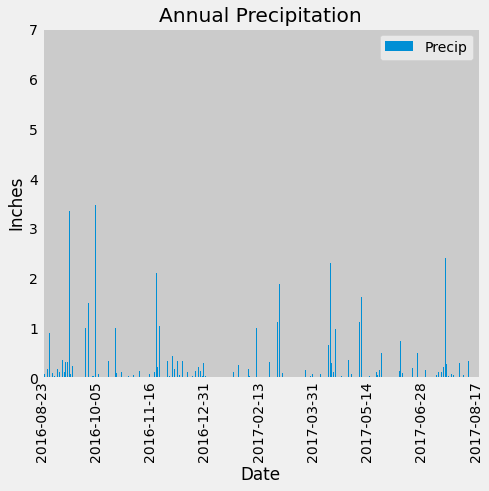

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
min_date = prcp_df.first_valid_index()
max_date = prcp_df.last_valid_index()
ax = prcp_df.plot(kind="bar")
n = 250
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
fig = ax.get_figure()
fig.set_size_inches(7,6)
ax.set_title("Annual Precipitation")
ax.set_xlabel("Date")
ax.set_ylabel("Inches")
plt.show()


In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
active_min_prcp = prcp_df["Precip"].min()
active_max_prcp = prcp_df["Precip"].max()
active_avg_prcp = prcp_df["Precip"].mean()
print(active_min_prcp)
print(active_max_prcp)
print(active_avg_prcp)

0.0
6.7
0.17727857496288899


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number stations in the dataset
stations = []
for station in session.query(Measurement.station).distinct():
    stations.append(Station.station)

count = len(stations)
print(count)

9


In [21]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_counts = []
station_counts = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).all()
counts_df = pd.DataFrame(station_counts)
counts_df.rename(columns={0: "Station", 1: "Occurrences"}, inplace=True)
counts_df.sort_values(by="Occurrences", ascending=False, inplace=True)
counts_df.reset_index()
counts_df

,Station,Occurrences
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active = counts_df['Station'].iloc[0]
active_df = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.station == active).all()
# Save the query results as a Pandas DataFrame, rename columns, delete nulls, sort
active_df = pd.DataFrame(active_df)
active_df.rename(columns={0: "Station", 1: "Date", 2: "Temp"}, inplace=True)
active_df.dropna(subset = ["Temp"], inplace=True)
active_df.sort_values(by="Temp", ascending=False, inplace=True)
active_df.reset_index(inplace=True)
#active_min_temp = active_df["Temp"].min()
active_min_temp = session.query(Measurement.date, func.min(Measurement.tobs)).filter(Measurement.station == active).all()
#active_max_temp = active_df["Temp"].max()
active_max_temp = session.query(Measurement.date, func.max(Measurement.tobs)).filter(Measurement.station == active).all()
#active_avg_temp = active_df["Temp"].mean()
active_avg_temp = session.query(Measurement.date, func.avg(Measurement.tobs)).filter(Measurement.station == active).all()
active_tot_temp = session.query(func.count(Measurement.tobs)).filter(Measurement.station == active).all()

print(active_min_temp)
print(active_max_temp)
print(active_avg_temp)
print(active_tot_temp)

[('2013-01-16', 54.0)]
[('2015-09-10', 85.0)]
[('2010-01-01', 71.66378066378067)]
[(2772,)]


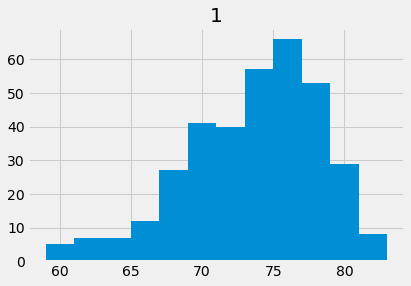

In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
prior_year_temps = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == active, Measurement.date >= year_prior).all()
tobs_df = pd.DataFrame(prior_year_temps)
tobs_hist = tobs_df.hist(bins=12)

# Close session

In [24]:
# Close Session
session.close()